In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class GCN(nn.Module):

    def __init__(self, in_size, hidden_sizes, out_size):
        super(GCN, self).__init__()
        self.in_size = in_size
        self.hidden_sizes = hidden_sizes
        self.out_size = out_size

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(in_size, hidden_sizes[0], bias=False))
        for i in range(1, len(hidden_sizes)):
            self.layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i], bias=False))
        self.layers.append(nn.Linear(hidden_sizes[-1], out_size))

    def get_embedding(self, feature_aggregation_matrix, X):
        for layer in self.layers[:-1]:
            X = F.tanh(layer(feature_aggregation_matrix @ X)) # tanh for visualizing the embeddings
        return X

    def forward(self, feature_aggregation_matrix, X):
        X = self.get_embedding(feature_aggregation_matrix, X)
        logits = self.layers[-1](X)
        return F.softmax(logits, dim=1)

Epoch 0: Test Loss 1.156, Test Acc 0.226
Epoch 100: Test Loss 0.730, Test Acc 0.871
Epoch 200: Test Loss 0.698, Test Acc 0.871
Epoch 300: Test Loss 0.689, Test Acc 0.871
Epoch 400: Test Loss 0.685, Test Acc 0.871
Epoch 500: Test Loss 0.683, Test Acc 0.871
Epoch 600: Test Loss 0.681, Test Acc 0.871
Epoch 700: Test Loss 0.680, Test Acc 0.871
Epoch 800: Test Loss 0.679, Test Acc 0.871
Epoch 900: Test Loss 0.679, Test Acc 0.871
Epoch 1000: Test Loss 0.678, Test Acc 0.871
Epoch 1100: Test Loss 0.678, Test Acc 0.871
Epoch 1200: Test Loss 0.678, Test Acc 0.871
Epoch 1300: Test Loss 0.677, Test Acc 0.871
Epoch 1400: Test Loss 0.677, Test Acc 0.871
Epoch 1500: Test Loss 0.677, Test Acc 0.871
Epoch 1600: Test Loss 0.677, Test Acc 0.871
Epoch 1700: Test Loss 0.677, Test Acc 0.871
Epoch 1800: Test Loss 0.677, Test Acc 0.871
Epoch 1900: Test Loss 0.677, Test Acc 0.871
Epoch 2000: Test Loss 0.676, Test Acc 0.871
Epoch 2100: Test Loss 0.676, Test Acc 0.871
Epoch 2200: Test Loss 0.676, Test Acc 0.871


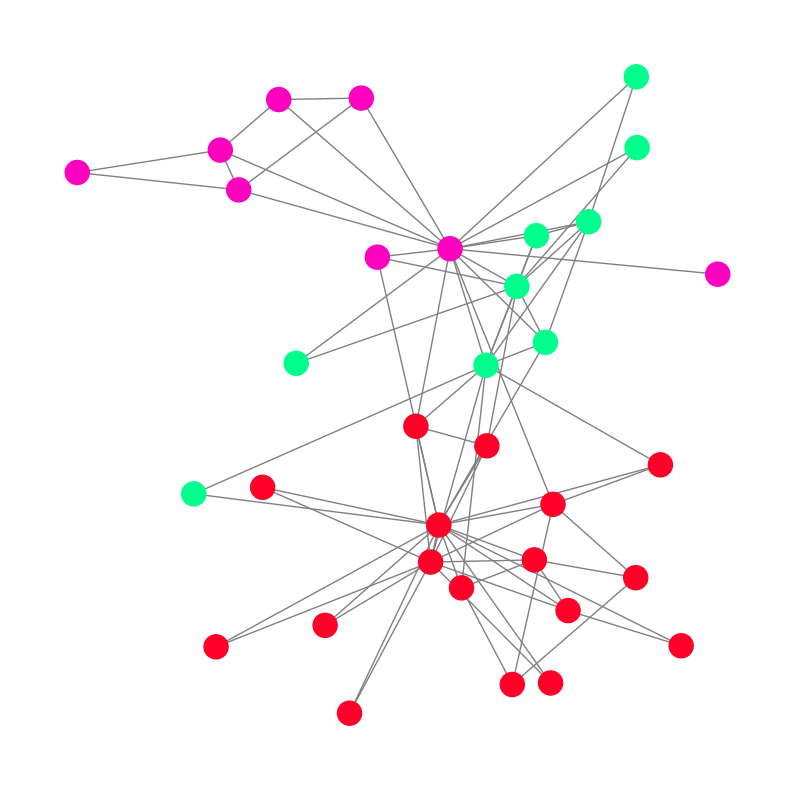

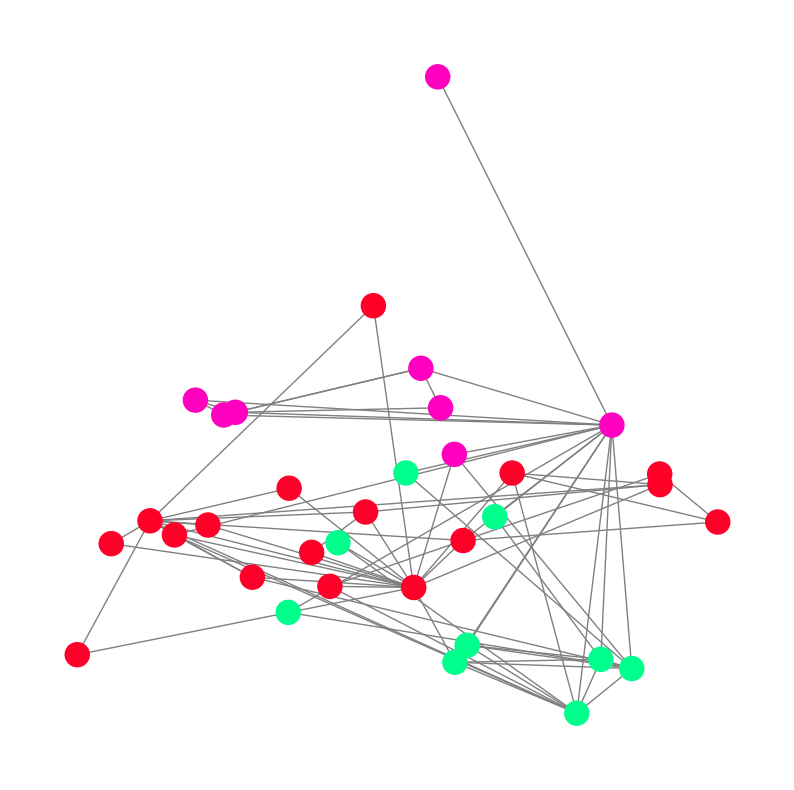

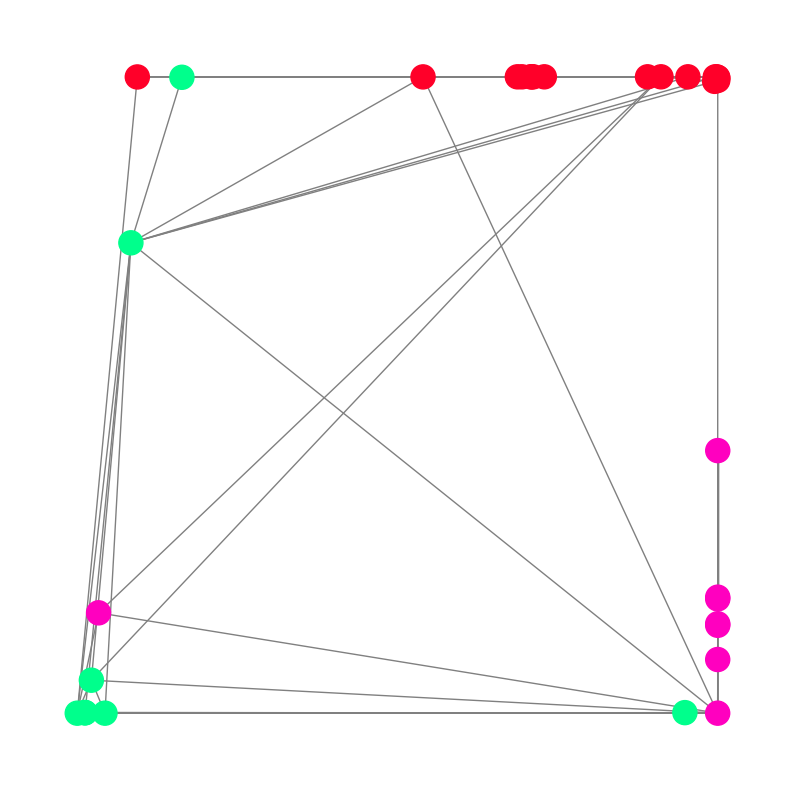

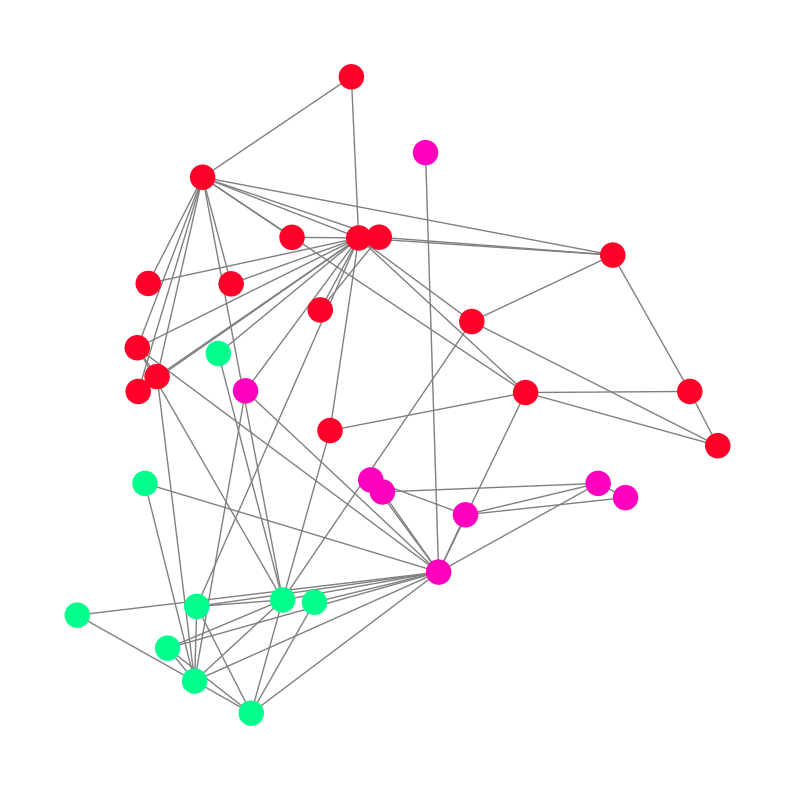

In [35]:
### Just for testing purpose ###
""" Borrow from here (https://github.com/zjost/blog_code/blob/master/gcn_numpy/gcn_from_scratch.ipynb) """

import numpy as np
import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML


# Utility functions
def draw_kkl(nx_G, label_map, node_color, pos=None, **kwargs):
    fig, ax = plt.subplots(figsize=(10,10))
    if pos is None:
        pos = nx.spring_layout(nx_G, k=5/np.sqrt(nx_G.number_of_nodes()))

    nx.draw(
        nx_G, pos, with_labels=label_map is not None, 
        labels=label_map, 
        node_color=node_color, 
        ax=ax, **kwargs)


g = nx.karate_club_graph()

# Visualization
communities = greedy_modularity_communities(g)
colors = np.zeros(g.number_of_nodes())
for i, com in enumerate(communities):
    colors[list(com)] = i
n_classes = np.unique(colors).shape[0]
labels = torch.eye(n_classes)[colors.astype(int)] # We use the community labels as ground truth
# club_labels = nx.get_node_attributes(g, 'club')
draw_kkl(g, None, colors, cmap='gist_rainbow', edge_color='gray')

# GCN (https://arxiv.org/pdf/1609.02907.pdf)
A = nx.to_numpy_array(g, weight=None)
A_tilde = A + np.eye(g.number_of_nodes())  # A_tilde = A + I
D_tilde = np.diagflat(np.sum(A_tilde, axis=1)) # D_tilde_ii = sum_j(A_tilde_ij)
D_tilde_inv_sqrt = np.linalg.inv(np.sqrt(D_tilde))
feature_aggregation_matrix = torch.tensor(D_tilde_inv_sqrt @ A_tilde @ D_tilde_inv_sqrt, dtype=torch.float32)

X = torch.eye(g.number_of_nodes(), dtype=torch.float32)
gcn_model = GCN(in_size=g.number_of_nodes(), hidden_sizes=[16, 2], out_size=n_classes)

# Pre-training visualization
with torch.no_grad():
    embed = gcn_model.get_embedding(feature_aggregation_matrix, X).numpy()
    pos = {i: embed[i,:] for i in range(embed.shape[0])}
    _ = draw_kkl(g, None, colors, pos=pos, cmap='gist_rainbow', edge_color='gray')

# Training
train_nodes = np.array([0, 1, 8])
test_nodes = np.array([i for i in range(X.shape[0]) if i not in train_nodes])
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

embeds = []
for epoch in range(15000):
    y_pred = gcn_model(feature_aggregation_matrix, X)
    loss = loss_fn(y_pred[train_nodes], labels[train_nodes].argmax(axis=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    embeds.append(gcn_model.get_embedding(feature_aggregation_matrix, X).detach().numpy())
    if epoch % 100 == 0:
        acc_test = (y_pred[test_nodes].argmax(axis=1) == labels[test_nodes].argmax(axis=1)).float().mean().item()
        loss_test = loss_fn(y_pred[test_nodes], labels[test_nodes].argmax(axis=1)).item()
        print(f"Epoch {epoch}: Test Loss {loss_test:.3f}, Test Acc {acc_test:.3f}")

# Post-training visualization
pos = {i: embeds[-1][i,:] for i in range(embeds[-1].shape[0])}
_ = draw_kkl(g, None, colors, pos=pos, cmap='gist_rainbow', edge_color='gray')

# Visualize learning process
N = 500
snapshots = np.linspace(0, len(embeds)-1, N).astype(int)
fig, ax = plt.subplots(figsize=(10, 10))
kwargs = {'cmap': 'gist_rainbow', 'edge_color': 'gray', }#'node_size': 55}

def update(idx):
    ax.clear()
    embed = embeds[snapshots[idx]]
    pos = {i: embed[i,:] for i in range(embed.shape[0])}
    nx.draw(g, pos, node_color=colors, ax=ax, **kwargs)

anim = animation.FuncAnimation(fig, update, frames=snapshots.shape[0], interval=10, repeat=False)
HTML(anim.to_html5_video())
anim.save('embed_anim.mp4', dpi=300)